<a href="https://colab.research.google.com/github/Ibnuamrithaher/Deep-Learning/blob/main/16%20-%20Recurrent%20Neural%20Network/Part%207%20-%20Tuning%20Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "jcopdl==1.1.1"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12587 sha256=9bf628ddb0c0b644a675db25f1c6999fe3675956b8f3b6a72117fcea0649ff90
  Stored 

In [8]:
!gdown https://drive.google.com/uc?id=1FbwBijisSEymWLhfpP9CDVKm1oAQZ3nc
!unzip "data (4).zip"

Downloading...
From: https://drive.google.com/uc?id=1FbwBijisSEymWLhfpP9CDVKm1oAQZ3nc
To: /content/data (4).zip
100% 95.8k/95.8k [00:00<00:00, 4.61MB/s]
Archive:  data (4).zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: data/sine_new.csv       
   creating: data/.ipynb_checkpoints/
  inflating: data/jkse.csv           
  inflating: data/daily_min_temp.csv  
  inflating: data/sine.csv           


In [2]:
from jcopdl.callback import set_config

In [21]:
# data = "damped_sine"
# config = set_config({
#     "input_size": 1,
#     "seq_len": 2,
#     "batch_size": 32,
#     "output_size": 1,
#     "hidden_size": 256,
#     "num_layers": 2,
#     "dropout": 0.2,
#     "bidirectional": True, # True/False
#     "cell_type": "lstm" # rnn/gru/lstm
# })
# lr = 0.0005



data = "jkse"
config = set_config({
    "input_size": 1,
    "seq_len": 2,
    "batch_size": 32,
    "output_size": 1,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout": 0.2,
    "bidirectional": True, # True/False
    "cell_type": "lstm" # rnn/gru/lstm
})
lr = 0.0005

# Jangan edit code di bawah ini

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

(N, S, F): (969, 2, 1)
Note: last 1 data excluded

(N, S, F): (242, 2, 1)
Note: last 1 data excluded



Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6632 | Test_cost  = 0.1758 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3428 | Test_cost  = 0.4542 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1758


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.0078 | Test_cost  = 1.1309 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1758


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5567 | Test_cost  = 0.5484 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1758


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1963 | Test_cost  = 0.1324 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0419 | Test_cost  = 0.1556 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1324


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1081 | Test_cost  = 0.1271 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0441 | Test_cost  = 0.1690 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1271


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0759 | Test_cost  = 0.1031 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0460 | Test_cost  = 0.1700 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1031


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0810 | Test_cost  = 0.0840 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0419 | Test_cost  = 0.1447 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0840


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0654 | Test_cost  = 0.0796 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0375 | Test_cost  = 0.1373 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0796


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0561 | Test_cost  = 0.0742 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0345 | Test_cost  = 0.1309 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0742


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0509 | Test_cost  = 0.0694 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0327 | Test_cost  = 0.1253 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0694


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0481 | Test_cost  = 0.0640 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0321 | Test_cost  = 0.1212 | 


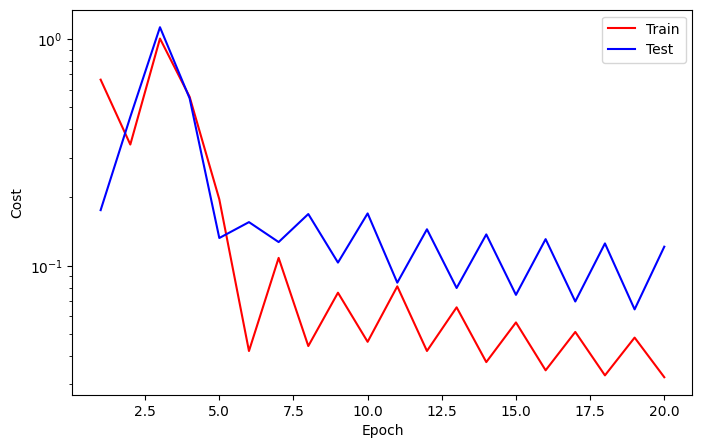

==> EarlyStop patience =  1 | Best test_cost: 0.0640


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0477 | Test_cost  = 0.0587 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0315 | Test_cost  = 0.1186 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0587


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0477 | Test_cost  = 0.0544 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0312 | Test_cost  = 0.1136 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0544


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0467 | Test_cost  = 0.0505 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0304 | Test_cost  = 0.1100 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0505


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0456 | Test_cost  = 0.0479 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0298 | Test_cost  = 0.1095 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0479


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0446 | Test_cost  = 0.0454 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0291 | Test_cost  = 0.1062 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0454


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0434 | Test_cost  = 0.0414 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0287 | Test_cost  = 0.1037 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0414


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0433 | Test_cost  = 0.0395 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0281 | Test_cost  = 0.1031 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0395


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0433 | Test_cost  = 0.0374 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0282 | Test_cost  = 0.1027 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0374


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0438 | Test_cost  = 0.0353 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0277 | Test_cost  = 0.1012 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0353


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0432 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0271 | Test_cost  = 0.0987 | 


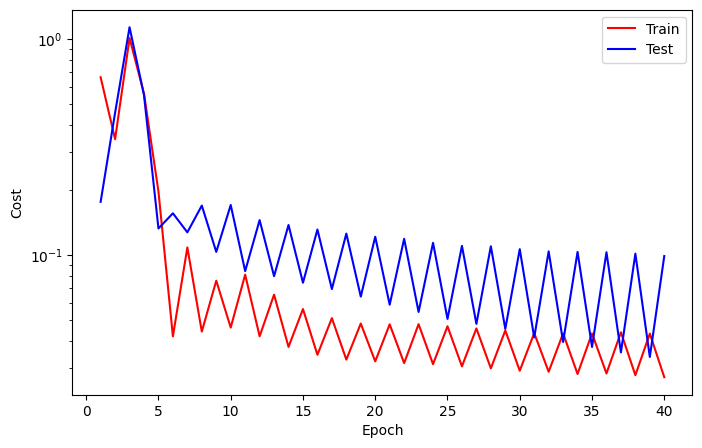

==> EarlyStop patience =  1 | Best test_cost: 0.0337


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0419 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0268 | Test_cost  = 0.0995 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0321


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0421 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0270 | Test_cost  = 0.1003 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0312


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.0415 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.0265 | Test_cost  = 0.0996 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0292


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.0419 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.0261 | Test_cost  = 0.0992 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0275


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.0407 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.0253 | Test_cost  = 0.0950 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0247


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.0396 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.0247 | Test_cost  = 0.0942 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0236


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.0392 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.0244 | Test_cost  = 0.0927 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0218


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.0386 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.0237 | Test_cost  = 0.0928 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0211


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.0374 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.0238 | Test_cost  = 0.0924 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0202


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.0374 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.0239 | Test_cost  = 0.0927 | 


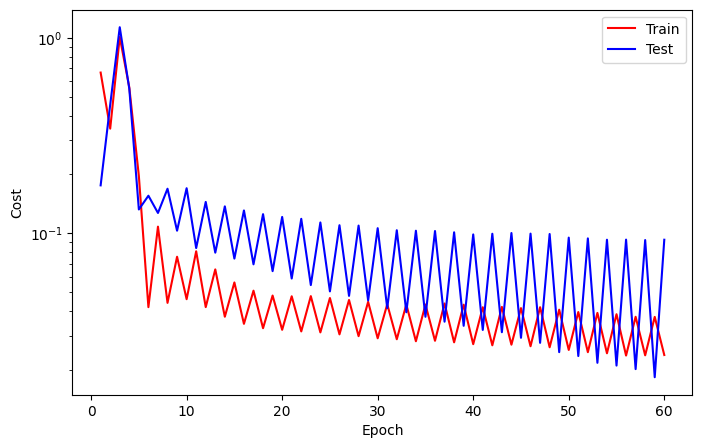

==> EarlyStop patience =  1 | Best test_cost: 0.0184


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.0379 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.0236 | Test_cost  = 0.0904 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0170


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.0374 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.0231 | Test_cost  = 0.0903 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0166


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.0378 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.0232 | Test_cost  = 0.0915 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0163


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.0371 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.0225 | Test_cost  = 0.0903 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0156


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.0365 | Test_cost  = 0.0144 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.0224 | Test_cost  = 0.0889 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0144


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.0358 | Test_cost  = 0.0134 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.0232 | Test_cost  = 0.0925 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0134


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.0381 | Test_cost  = 0.0133 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.0232 | Test_cost  = 0.0908 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0133


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.0379 | Test_cost  = 0.0133 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0133


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.0237 | Test_cost  = 0.0918 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0133


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.0371 | Test_cost  = 0.0117 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.0224 | Test_cost  = 0.0883 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0117


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.0363 | Test_cost  = 0.0110 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.0223 | Test_cost  = 0.0882 | 


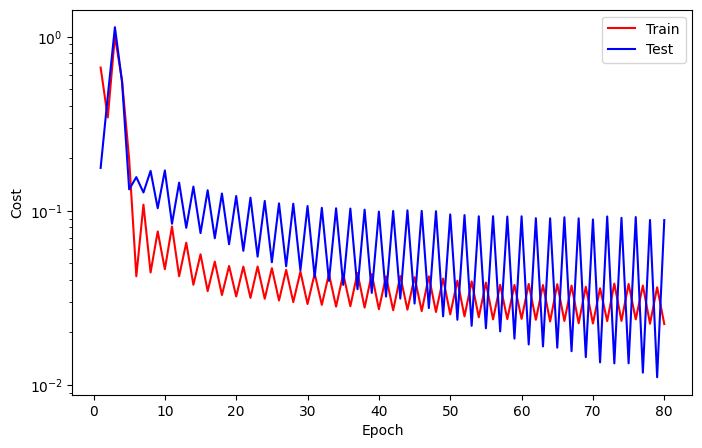

==> EarlyStop patience =  1 | Best test_cost: 0.0110


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.0355 | Test_cost  = 0.0108 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.0217 | Test_cost  = 0.0883 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0108


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.0353 | Test_cost  = 0.0104 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.0219 | Test_cost  = 0.0885 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0104


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.0349 | Test_cost  = 0.0095 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.0219 | Test_cost  = 0.0855 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0095


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.0355 | Test_cost  = 0.0099 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0095


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.0221 | Test_cost  = 0.0882 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0095


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.0350 | Test_cost  = 0.0092 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.0220 | Test_cost  = 0.0863 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0092


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.0351 | Test_cost  = 0.0093 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0092


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.0223 | Test_cost  = 0.0896 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0092


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.0352 | Test_cost  = 0.0085 | 


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.0226 | Test_cost  = 0.0886 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0085


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.0366 | Test_cost  = 0.0090 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0085


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.0220 | Test_cost  = 0.0892 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0085


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.0352 | Test_cost  = 0.0085 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0085


Train:   0%|          | 0/31 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.0224 | Test_cost  = 0.0901 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0085
==> Execute Early Stopping at epoch: 98 | Best test_cost: 0.0085
==> Best model is saved at model/jkse/


/usr/local/lib/python3.11/dist-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f'{self.outdir}/weights_best.pth

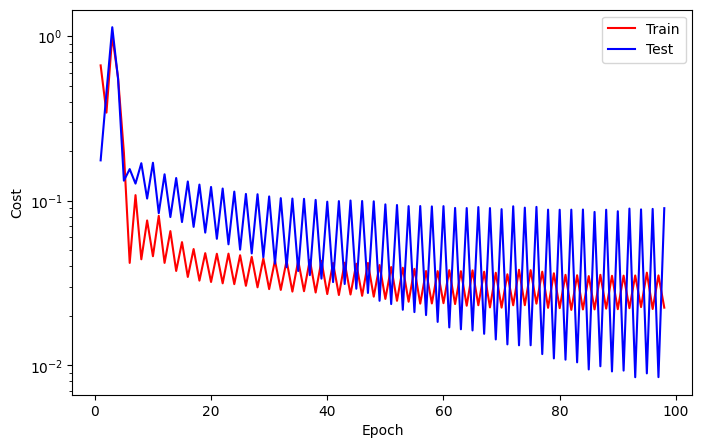

(N, S, F): (1939, 1, 1)
Note: last 0 data excluded

(N, S, F): (485, 1, 1)
Note: last 0 data excluded



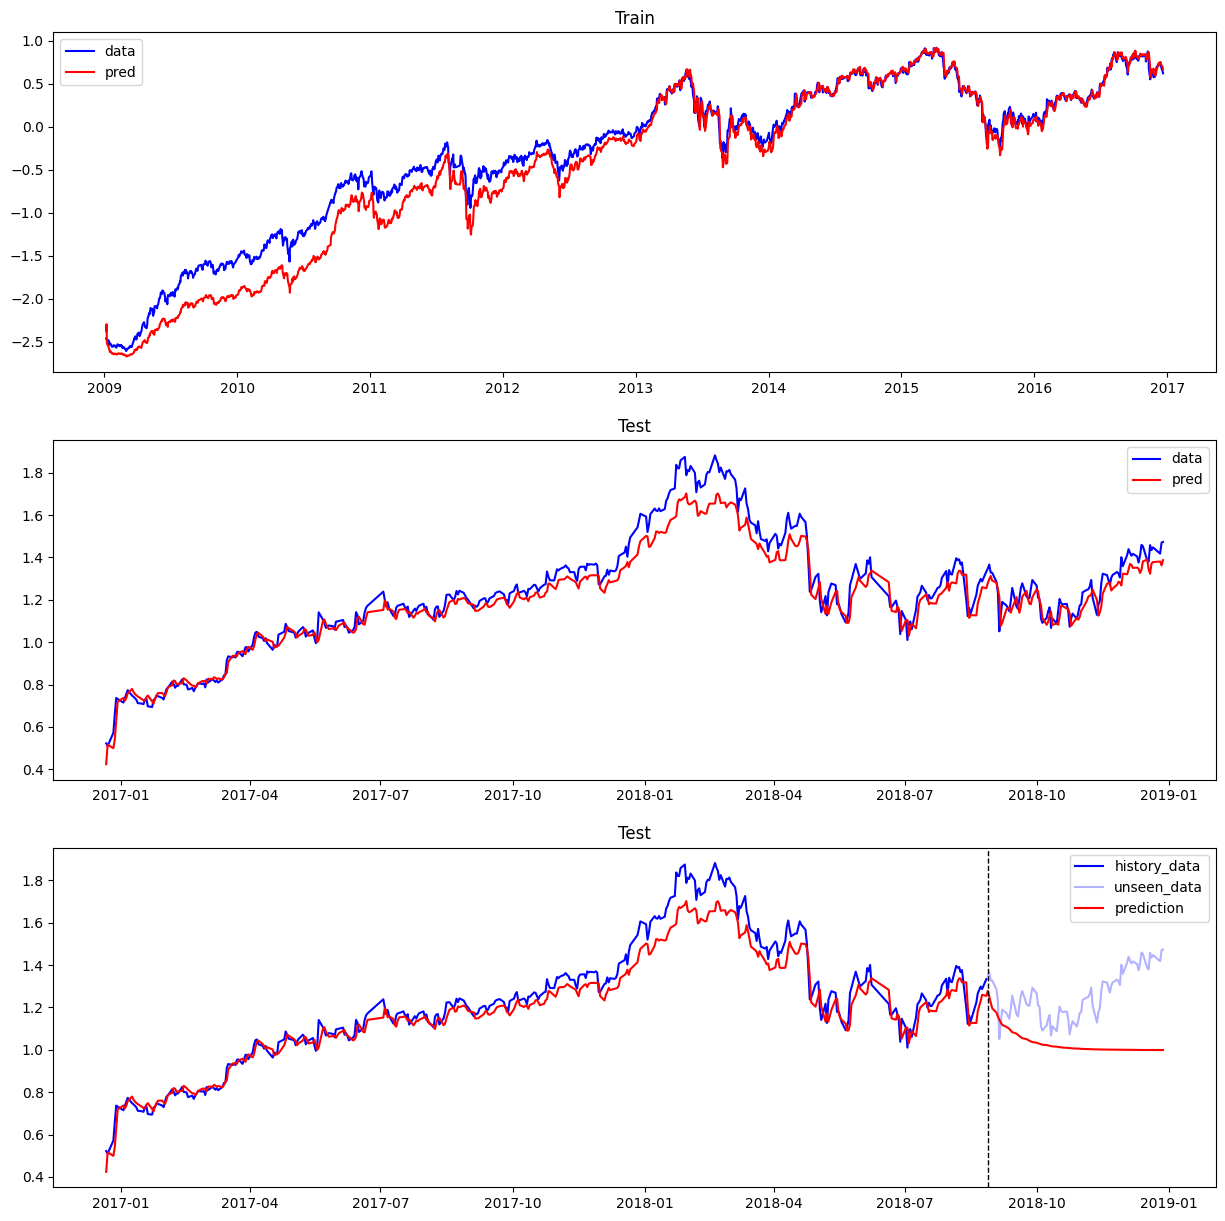

In [22]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, output_size, hidden_size, num_layers, dropout, bidirectional):
        super().__init__()

        if cell_type == "rnn":
            rnn_block = nn.RNN
        elif cell_type == "lstm":
            rnn_block = nn.LSTM
        elif cell_type == "gru":
            rnn_block = nn.GRU

        self.rnn = rnn_block(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)

        if bidirectional:
            hidden_size = 2*hidden_size

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

if data == "damped_sine":
    df = pd.read_csv("data/sine_new.csv", parse_dates=["Date"], index_col="Date")
    df.value = df.value.transform(lambda x: (x-x.mean())/x.std())
    col = "value"
elif data == "jkse":
    df = pd.read_csv("data/jkse.csv", parse_dates=["Date"], index_col="Date")
    df = df[~df.price.isna()]
    df.price = df.price.transform(lambda x: (x-x.mean())/x.std())
    col = "price"

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)

train_set = TimeSeriesDataset(ts_train, col, config.seq_len)
trainloader = DataLoader(train_set, batch_size=config.batch_size)

test_set = TimeSeriesDataset(ts_test, col, config.seq_len)
testloader = DataLoader(test_set, batch_size=config.batch_size)

model = RNN(config.cell_type, config.input_size, config.output_size, config.hidden_size,
            config.num_layers, config.dropout, config.bidirectional).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=lr)
callback = Callback(model, config, outdir=f'model/{data}/')

from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast
train_forecast_set = TimeSeriesDataset(ts_train, col, 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, col, 1)
testforecastloader = DataLoader(test_forecast_set)

plt.figure(figsize=(15, 15))

plt.subplot(311)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(312)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

plt.subplot(313)
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=400, n_forecast=100)
plt.title("Test");